### Import libraries for experiments

In [1]:
import torch
from training_main import training_main, test
from utils import data_loading, normalization, filter_extraction, plot_results, plot_kernels
from CNN import CNN
from ScatNet import ScatNet2D
from kymatio.torch import Scattering2D
from scipy.fft import fft2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

## Data Loading and Normalization

In [2]:
# LOAD DATA
train_data, train_labels, test_data, test_labels = data_loading("./data/train/", "./data/test/")
data = train_data + test_data

# NORMALIZATION
data_transform = normalization(data)

Red ch mean =  0.2082946035683011 
Green ch mean =  0.2082298517705837 
Blue ch mean =  0.2082241406070435
Red ch std =  0.2120124417706629 
Green ch std =  0.211990008277464 
Blue ch std =  0.2119912744425196


Example images

Image shape: (512, 512, 3)


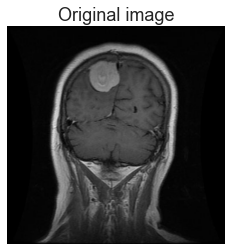

In [18]:
random.seed(42) 
image = random.sample(train_data, 1)
image = np.array(image)
image = np.squeeze(image, 0)
print(f"Image shape: {image.shape}")

plt.imshow(image)
plt.axis('off')
plt.title('Original image')
plt.show()

## CNN

In [10]:
MODEL_NAME = 'CNN'
NUM_FOLD = 10
num_epochs = 20

In [11]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))
model_CNN = CNN(input_channel=3, num_classes=2)
model_CNN.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_CNN.parameters():
    parameter.requires_grad = False


In [12]:
model_CNN

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

In [14]:
# TESTING
acc_CNN = test(data_transform, test_data, test_labels, model_CNN, MODEL_NAME, device='cpu')
print("Accuracy", acc_CNN)


Accuracy 0.7433333333333333


<Figure size 504x360 with 0 Axes>

### Extract Filters from CNN

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_CNN = model_CNN.to(device)

In [20]:
# Filter extraction
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image = data_transform(image)
image = image.to(device)

filter_extraction(model_CNN, MODEL_NAME, image)

Total convolution layers: 4


## ScatNet 

In [21]:
MODEL_NAME = 'ScatNet'
NUM_FOLD = 10
num_epochs = 20

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
# LOAD BEST MODEL
max_val_accuracies = np.zeros([NUM_FOLD, 1])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    max_val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])
    
index = np.argmax(max_val_accuracies)

model_string = f"./models_trained/{MODEL_NAME}/checkpoint_" + str(index) + ".pth"
checkpoint = torch.load(model_string, map_location=torch.device("cpu"))

# Define best model
L = 8
J = 2
scattering = Scattering2D(J=J, shape=(128, 128), L=L)
K = 81  # Input channels for the ScatNet
scattering = scattering.to(device)
model_ScatNet = ScatNet2D(input_channels=K, scattering=scattering, num_classes=2).to(device)
model_ScatNet.load_state_dict(checkpoint["model_state_dict"])

for parameter in model_ScatNet.parameters():
    parameter.requires_grad = False

In [24]:
model_ScatNet

ScatNet2D(
  (scattering): Scattering2D()
  (lin): Linear(in_features=248832, out_features=576, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [ ]:
# PLOTTING RESULTS
val_accuracies = np.zeros([NUM_FOLD, num_epochs])
train_losses = np.zeros([NUM_FOLD, num_epochs])
val_losses = np.zeros([NUM_FOLD, num_epochs])
f1_scores = np.zeros([NUM_FOLD, num_epochs])

for i in range(NUM_FOLD):
    results_string = f"./csv/{MODEL_NAME}/results_df_" + str(i) + ".csv"
    val_accuracies[i] = (pd.read_csv(results_string)["val_acc"]).to_list()
    val_losses[i] = (pd.read_csv(results_string)["val_loss"]).to_list()
    train_losses[i] = (pd.read_csv(results_string)["train_loss"]).to_list()
    f1_scores[i] = (pd.read_csv(results_string)["val_f1"]).to_list()

plot_results(val_accuracies, train_losses, val_losses, f1_scores, MODEL_NAME)

In [26]:
# TESTING
acc_ScatNet = test(data_transform, test_data, test_labels, model_ScatNet, MODEL_NAME, device='cpu')
print("Accuracy", acc_ScatNet)

Accuracy 0.495


<Figure size 504x360 with 0 Axes>

### Extract Filters from ScatNet

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ScatNet = model_ScatNet.to(device)

In [28]:
# Filter extraction
scatter = model_ScatNet.scattering
plot_kernels(J, L, scatter, MODEL_NAME)

## INTEGRATED GRADIENTS

## Comparing XAI methods